<a href="https://colab.research.google.com/github/RSNA/AI-Deep-Learning-Lab-2024/blob/main/sessions/cxr-tf/Building_a_Simple_CXR_Classification_Model_with_TensorFlow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

*Authors:*
*Jason Adleberg [@pixels2patients](https://twitter.com/pixels2patients), [LinkedIn](https://www.linkedin.com/in/jason-adleberg-6b444b52) and
Nicholas Primiano, [LinkedIn](https://www.linkedin.com/in/nicholas-j-primiano-47077792/)*

#NIH CXR8 **Classification** Tutorial
**_Estimated completion time: 30 minutes_**

Welcome!
In this presentation, we will break down the process into five steps:

1. **Defining a problem**: what do we want our model to look for? For this we'll need to think of pathology we might find in a chest x-ray.
2. **Data preparation**: we'll talk about how to manipulate our data in a way the classification model can understand.
3. **Training a model**: we'll use a technology called [TensorFlow](
https://wwww.tensorflow.org) to create our model.
4. **Evaluating model performace**: we'll talk about some important considerations when creating a model like this.
5. **Deployment**: we'll send our model to a website where we can then test it in the wild and send to others.

##i. Using Google Colab

This demonstration will take place in Google Colab. Please first sign in with your Google account, and click **File -> Save a copy** in Drive.

When you get into the draft environment, please ensure that you see "GPU on" and "Internet on" under Settings so you can utilize the cloud GPU for faster model training.

In this Notebook editing environment, each block of text is referred to as a cell. Cells containing formatted text are Markdown cells, as they use the Markdown formatting language. Similarly, cells containing code are code cells.

Clicking within a cell will allow you to edit the content of that cell (a.k.a. enter edit mode). You can also navigate between cells with the arrow keys. Note that the appearance of Markdown cells will change when you enter edit mode.

You can run code cells (and format Markdown cells) as you go along by clicking within the cell and then clicking the blue button with one arrow next to the cell or at the bottom of the window. You can also use the keyboard shortcut SHIFT + ENTER (press both keys at the same time).

Let's try this out by running the cell below. This will help us load the technologies we need to power our model.

In [ ]:
%matplotlib inline

import sklearn.metrics
import random
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import io
import glob
import scipy.misc
import numpy as np
import pandas as pd
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont
import shutil
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import layers
from tensorflow.keras import Model
import matplotlib
from tensorflow.keras.optimizers import RMSprop
import os
import zipfile
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.image as mpimg
from matplotlib.ticker import FormatStrFormatter
from tensorflow.keras.utils import plot_model


LEARNING_RATE = 0.0001
repo_url = 'https://github.com/adleberg/medical-ai'
IMAGE_HEIGHT, IMAGE_WIDTH = 299, 299

def load_image_into_numpy_array(image):
    image = image.convert('RGB')
    (im_width, im_height) = image.size
    return np.array(image.getdata()).reshape(
        (im_height, im_width, 3)).astype(np.uint8)

print("Welcome! Downloading some things... this will take a minute.")

%cd -q /content
repo_dir_path = os.path.abspath(os.path.join('.', os.path.basename(repo_url)))
!git clone {repo_url} --quiet
%cd -q {repo_dir_path}
!git pull -q

!apt-get install graphviz -y
!pip install pydot

print("Great! You clicked on it correctly. Now let's get started.")

Welcome! Downloading some things... this will take a minute.
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
graphviz is already the newest version (2.42.2-6ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.
Great! You clicked on it correctly. Now let's get started.


##1. Defining a Problem
Great! Let's start by thinking of something we can look for in a chest xray.

Once we think of something, let's type it in below, in between the quotes `""`, and run the cell. I'll put in `"atelectasis"` by default, but let's see if we can think of something else.

We'll be using a subset of the [NIH CXR8 dataset](https://openaccess.thecvf.com/content_cvpr_2017/papers/Wang_ChestX-ray8_Hospital-Scale_Chest_CVPR_2017_paper.pdf) for this project, but this principles here apply to any project. The NIH CXR8 dataset only has a few selected findings within its dataset, but let's pretend that we're creating a dataset from scratch (using Montage, e.g.). Of note, this dataset also has bounding boxes available to us for another demonstration on object detection.

We'll need to see how many examples there are of the finding we typed in. Let's run the cell below to see.

Screen Shot 2020-11-08 at 1.14.35 PM.png

Above are the labels we have available to us in this dataset.

In [ ]:
finding = "cardiomegaly"
finding = finding.capitalize()

In [ ]:
df = pd.read_csv("/content/medical-ai/labels.csv")
df.head()

,filename,height,width,label,xmin,ymin,xmax,ymax,view
0,00013118_008.jpg,2992,2991,Atelectasis,225.0,547.0,311.0,626.0,PA
1,00014716_007.jpg,3056,2544,Atelectasis,686.0,131.0,871.0,444.0,AP
2,00029817_009.jpg,3056,2544,Atelectasis,221.0,317.0,376.0,533.0,AP
3,00014687_001.jpg,2500,2048,Atelectasis,726.0,494.0,867.0,549.0,AP
4,00017877_001.jpg,2500,2048,Atelectasis,660.0,569.0,860.0,647.0,AP


In [ ]:
positives = df.loc[df["label"] == finding]
negatives = df.loc[df["label"] == "No Finding"]
n = len(positives)

if n == 0:
  print("No studies found! Maybe check your spelling?")
  assert (n > 0)

In [ ]:
TRAIN_RATIO = 0.8
TEST_RATIO = 0.2
n = len(positives)
TRAIN_N = int(n*TRAIN_RATIO)
TEST_N = int(n*TEST_RATIO)
print(TRAIN_N, TEST_N)

116 29


In [ ]:
train_labels = pd.concat([positives[:TRAIN_N], negatives[:TRAIN_N]])
test_labels = pd.concat([positives[TRAIN_N:], negatives[TRAIN_N:n]])

## 2. Preparing the Data

Now, we've figured out what we want our model to take a look at. Behind the scenes, we just need to sort the data into two folders: one with **negative** cases and one with **positive** cases.

In [ ]:
rootdir = "/content/medical-ai/images/"
os.makedirs(rootdir+finding+"/test/positive",  exist_ok=True)
os.makedirs(rootdir+finding+"/test/negative",  exist_ok=True)
os.makedirs(rootdir+finding+"/train/positive", exist_ok=True)
os.makedirs(rootdir+finding+"/train/negative", exist_ok=True)

In [ ]:
# copy images to new directories for training purposes
for idx, image in positives[:TRAIN_N].iterrows():
  source = rootdir+image["filename"]
  dst = rootdir+finding+"/train/positive/"+image["filename"]
  shutil.copy(source, dst)

for idx, image in positives[TRAIN_N:].iterrows():
  source = rootdir+image["filename"]
  dst = rootdir+finding+"/test/positive/"+image["filename"]
  shutil.copy(source, dst)

for idx, image in negatives[:TRAIN_N].iterrows():
  source = rootdir+image["filename"]
  dst = rootdir+finding+"/train/negative/"+image["filename"]
  shutil.copy(source, dst)

for idx, image in negatives[TRAIN_N:n].iterrows():
  source = rootdir+image["filename"]
  dst = rootdir+finding+"/test/negative/"+image["filename"]
  shutil.copy(source, dst)

print("Done moving "+str(n*2)+" images to positive and negative folders.")

Done moving 292 images to positive and negative folders.


In [ ]:
from PIL import Image, ImageDraw, ImageFont

# load images into memory for visualization
positive_imgs, negative_imgs = [], []
IMAGE_HEIGHT, IMAGE_WIDTH = 299, 299

for idx, row in positives[:6].iterrows():
  image_path = rootdir+row["filename"]
  image = Image.open(image_path).resize((IMAGE_WIDTH, IMAGE_HEIGHT))
  positive_imgs.append(load_image_into_numpy_array(image))

for idx, row in negatives[:6].iterrows():
  image_path = rootdir+row["filename"]
  image = Image.open(image_path).resize((IMAGE_WIDTH, IMAGE_HEIGHT))
  negative_imgs.append(load_image_into_numpy_array(image))

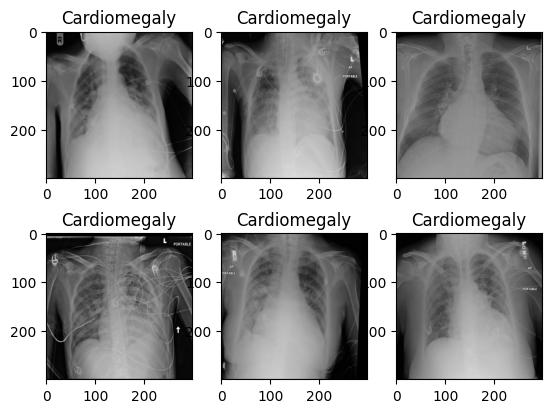

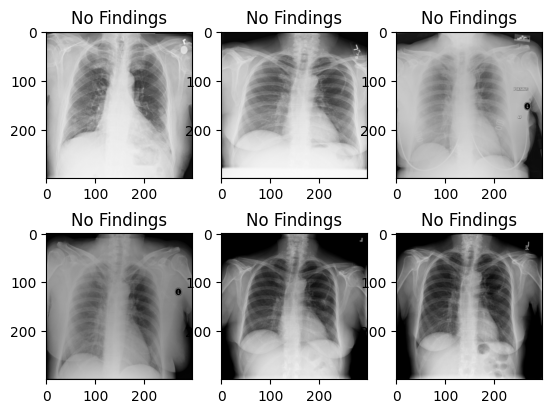

In [ ]:
for idx, img in enumerate(positive_imgs[:6]):
  plt.subplot(2, 3, idx+1)
  plt.title(finding)
  plt.imshow(positive_imgs[idx])
plt.show()

for idx, img in enumerate(negative_imgs[:6]):
  plt.subplot(2, 3, idx+1)
  plt.title("No Findings")
  plt.imshow(negative_imgs[idx])
plt.show()

##3. Running the Model

In this section, we'll set up our chest X-ray image classification model using a technique called transfer learning with the [InceptionV3](https://arxiv.org/abs/1512.00567v3) architecture. This means we'll use an existing model that has already learned to classify images and adapt it to work with our own set of chest X-rays.

Building a good model to classify medical images from scratch requires a large amount of data. To overcome this challenge, we can use a pre-trained model that has been trained on a large dataset of general images. For example, the InceptionV3 model has been trained on [ImageNet](https://www.image-net.org/), which contains over 1.4 million images across 1,000 different categories. While these categories are not medical images, the model has learned to recognize many visual features—such as edges, textures, and shapes—that are also present in chest X-rays.

In [ ]:
# Define our example directories and files
base_dir = rootdir = "/content/medical-ai/images/"
train_dir = os.path.join(base_dir, finding, 'train')
test_dir = os.path.join(base_dir, finding, 'test')

train_pos_dir = os.path.join(train_dir, 'positive')
train_neg_dir = os.path.join(train_dir, 'negative')
test_pos_dir = os.path.join(test_dir, 'positive')
test_neg_dir = os.path.join(test_dir, 'negative')

In [ ]:
BATCH_SIZE = 64
IMG_SIZE = (299, 299)
IMG_SHAPE = IMG_SIZE + (3,)
train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir, shuffle=True, batch_size=BATCH_SIZE, image_size=IMG_SIZE)
validation_dataset = tf.keras.utils.image_dataset_from_directory(test_dir, shuffle=True, batch_size=BATCH_SIZE, image_size=IMG_SIZE)

Found 232 files belonging to 2 classes.
Found 60 files belonging to 2 classes.


###3.1 Define the Base Model
We use the InceptionV3 model pre-trained on the ImageNet dataset as our base model.

In [ ]:
# Define the base model using InceptionV3
base_model = tf.keras.applications.InceptionV3(
    input_shape=IMG_SHAPE,
    include_top=False,  # Exclude the final classification layer
    weights='imagenet'  # Load weights pre-trained on ImageNet
)

# Freeze the base model to keep the pre-trained weights unchanged
base_model.trainable = False

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


###3.2 Data Augmentation
This part help us create more data by adding little tweaks to the data we have.

In [ ]:
# Define data augmentation layers to prevent overfitting
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomRotation(0.10),                    # Small rotation
    tf.keras.layers.RandomTranslation(0.05, 0.05),           # Translation
    tf.keras.layers.RandomContrast(0.1),                     # Contrast adjustment
    tf.keras.layers.RandomBrightness(0.1),                   # Brightness adjustment
    tf.keras.layers.RandomZoom(0.1, 0.1)])                   # Random zoom

###3.3 Putting it together
Here, we put it together.

We compile the model, telling it to focus on 'accuracy' as the evaluation metric.

In [ ]:
inputs = tf.keras.Input(shape=IMG_SHAPE)
x = data_augmentation(inputs) # Apply data augmentation
x = tf.keras.applications.inception_v3.preprocess_input(x)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.5)(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

# Define the complete model
model = tf.keras.Model(inputs, outputs)

# Compile the model with appropriate optimizer, loss function, and metrics
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

###3.4 Define Callbacks
Early stopping helps us to prevent overfitting (memorizing the data) by halting training when the validation loss stops improving.

In [ ]:
# Define early stopping callback to stop training when validation loss doesn't improve
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',           # Monitor validation loss
    patience=5,                   # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True     # Restore model weights from the epoch with the best value of the monitored quantity
)

##4. Train the Model
Finally, let's train the model using the features we extracted. We'll train on all 80% of the labels we have, and verify their accuracy on the remaining 20%.

In [ ]:
# Set the number of epochs for initial training
initial_epochs = 40

# Train the model with early stopping
history = model.fit(
    train_dataset,
    epochs=initial_epochs,
    validation_data=validation_dataset,
    callbacks=[early_stopping]
)

Epoch 1/40
4/4 ━━━━━━━━━━━━━━━━━━━━ 31s 4s/step - accuracy: 0.5216 - loss: 0.7806 - val_accuracy: 0.5500 - val_loss: 0.6979
Epoch 2/40
4/4 ━━━━━━━━━━━━━━━━━━━━ 20s 443ms/step - accuracy: 0.4692 - loss: 0.8087 - val_accuracy: 0.5333 - val_loss: 0.6791
Epoch 3/40
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 500ms/step - accuracy: 0.5601 - loss: 0.7120 - val_accuracy: 0.5833 - val_loss: 0.6774
Epoch 4/40
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 849ms/step - accuracy: 0.5569 - loss: 0.7535 - val_accuracy: 0.6333 - val_loss: 0.6449
Epoch 5/40
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 454ms/step - accuracy: 0.5357 - loss: 0.7457 - val_accuracy: 0.6167 - val_loss: 0.6277
Epoch 6/40
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 446ms/step - accuracy: 0.5959 - loss: 0.7060 - val_accuracy: 0.6667 - val_loss: 0.6203
Epoch 7/40
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 415ms/step - accuracy: 0.5599 - loss: 0.6837 - val_accuracy: 0.6500 - val_loss: 0.6418
Epoch 8/40
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 401ms/step - accuracy: 0.6517 - loss: 0.5987 - val_accuracy: 0.6833 - val_loss: 

###4.1 Fine-Tune the Model
Right now, our model is sort of smart. We'll change the learning rate so it doesn't jump to conclusions too quickly.

In [ ]:
base_model.trainable = True
fine_tune_at = 249 # specific to this architecture

# Freeze all layers before the fine_tune_at layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Recompile the model with a lower learning rate
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Set the number of epochs for fine-tuning
fine_tune_epochs = 40
total_epochs = initial_epochs + fine_tune_epochs  # Total epochs

# Continue training the model with fine-tuning
history_fine = model.fit(
    train_dataset,
    epochs=total_epochs,
    initial_epoch=history.epoch[-1],  # Start from the last epoch of initial training
    validation_data=validation_dataset,
    callbacks=[early_stopping]  # Use early stopping
)

Epoch 40/80
4/4 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - accuracy: 0.5137 - loss: 0.7856 - val_accuracy: 0.7167 - val_loss: 0.5188
Epoch 41/80
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 580ms/step - accuracy: 0.5313 - loss: 0.7499 - val_accuracy: 0.7167 - val_loss: 0.5134
Epoch 42/80
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 538ms/step - accuracy: 0.5273 - loss: 0.7044 - val_accuracy: 0.7167 - val_loss: 0.5079
Epoch 43/80
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 543ms/step - accuracy: 0.5670 - loss: 0.6836 - val_accuracy: 0.7333 - val_loss: 0.5043
Epoch 44/80
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 600ms/step - accuracy: 0.6478 - loss: 0.6255 - val_accuracy: 0.7500 - val_loss: 0.5006
Epoch 45/80
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 656ms/step - accuracy: 0.5788 - loss: 0.6656 - val_accuracy: 0.7500 - val_loss: 0.4974
Epoch 46/80
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 589ms/step - accuracy: 0.6825 - loss: 0.6162 - val_accuracy: 0.7333 - val_loss: 0.4937
Epoch 47/80
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 548ms/step - accuracy: 0.6690 - loss: 0.5953 - val_accuracy: 0.7167 - val

###4.2 Plotting the progress
Let's plot the training and test loss and accuracy to show it conclusively:

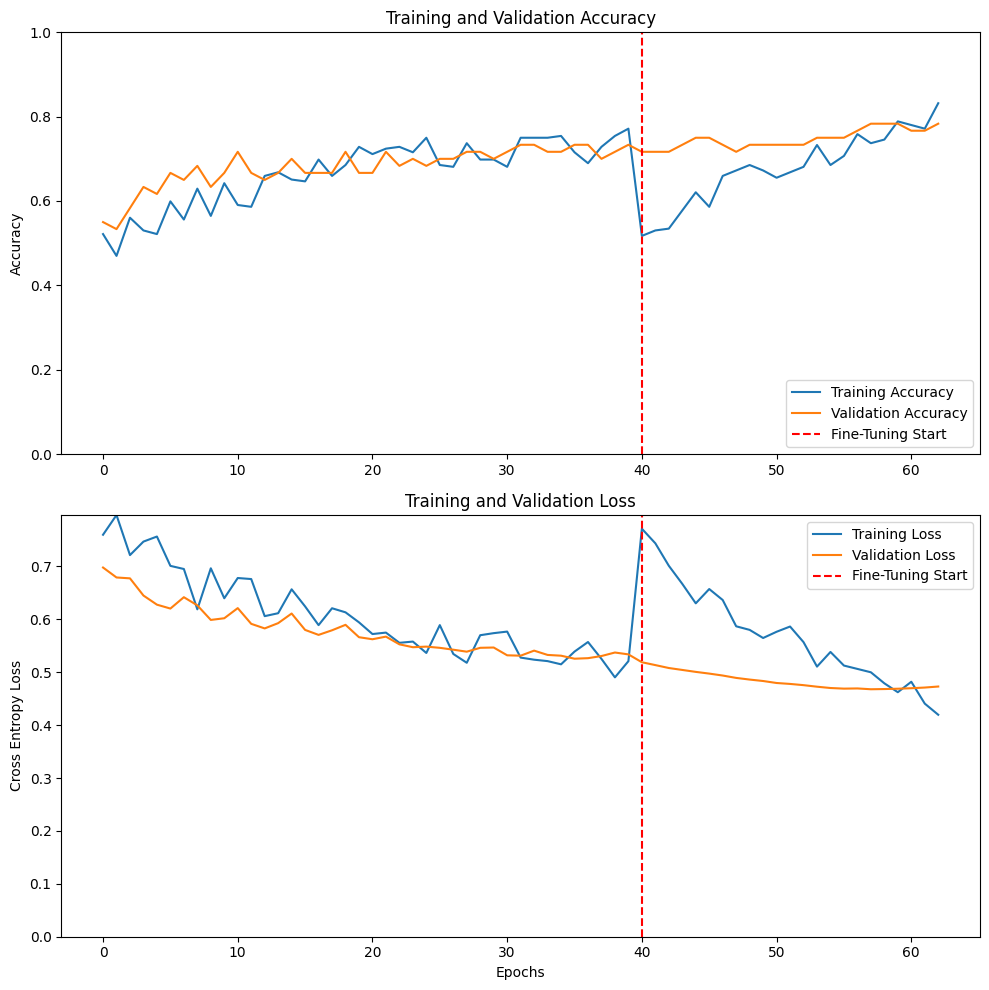

In [ ]:
# Combine histories
acc = history.history['accuracy'] + history_fine.history['accuracy']
val_acc = history.history['val_accuracy'] + history_fine.history['val_accuracy']
loss = history.history['loss'] + history_fine.history['loss']
val_loss = history.history['val_loss'] + history_fine.history['val_loss']

# Total epochs
total_epochs = len(acc)
fine_tune_start = initial_epochs  # Epoch where fine-tuning starts

plt.figure(figsize=(10, 10))

# Accuracy plot
plt.subplot(2, 1, 1)
plt.plot(range(total_epochs), acc, label='Training Accuracy')
plt.plot(range(total_epochs), val_acc, label='Validation Accuracy')
plt.axvline(x=fine_tune_start, color='r', linestyle='--', label='Fine-Tuning Start')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.title('Training and Validation Accuracy')

# Loss plot
plt.subplot(2, 1, 2)
plt.plot(range(total_epochs), loss, label='Training Loss')
plt.plot(range(total_epochs), val_loss, label='Validation Loss')
plt.axvline(x=fine_tune_start, color='r', linestyle='--', label='Fine-Tuning Start')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy Loss')
plt.ylim([0, max(max(loss), max(val_loss))])
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')

plt.tight_layout()
plt.show()


## 5. Evaluating Performance

In this section we will investigate how it works on different parts.

In [ ]:
def predict_image(filename):
  image = Image.open(filename).resize((IMAGE_HEIGHT, IMAGE_WIDTH))
  image_np = load_image_into_numpy_array(image)
  expanded = np.expand_dims(image_np, axis=0)
  return model.predict(expanded)[0][0]

def show_df_row(row):
  image_path = row["filepath"]
  image = Image.open(image_path).resize((IMAGE_WIDTH, IMAGE_HEIGHT))
  img = load_image_into_numpy_array(image)
  expanded = np.expand_dims(img, axis=0)
  pred = model.predict(expanded)[0][0]
  guess = "neg"
  if pred > 0.5:
    guess = "pos"
  title = "Image: "+row["filename"]+" Label: "+row["label"]+" Guess: "+guess+" Score: "+str(pred)
  plt.title(title)
  plt.imshow(img)
  plt.show()
  return

In [ ]:
results = []
for image in os.listdir(test_neg_dir):
  filename = test_neg_dir+"/"+image
  confidence = predict_image(filename)
  guess = 'pos' if confidence > 0.5 else 'neg'
  results.append([filename, image, "neg", guess, confidence])

for image in os.listdir(test_pos_dir):
  filename = test_pos_dir+"/"+image
  confidence = predict_image(filename)
  guess = 'pos' if confidence > 0.5 else 'neg'
  results.append([filename, image, "pos", guess, confidence])

sorted_results = sorted(results, key=lambda x: x[4], reverse=True)
df = pd.DataFrame(data=sorted_results, columns=["filepath","filename","label","guess","confidence"])

print("Done inference!")

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━

In [ ]:
df.head()

,filepath,filename,label,guess,confidence
0,/content/medical-ai/images/Cardiomegaly/test/p...,00013615_052.jpg,pos,pos,0.984043
1,/content/medical-ai/images/Cardiomegaly/test/p...,00030206_013.jpg,pos,pos,0.962622
2,/content/medical-ai/images/Cardiomegaly/test/p...,00004342_002.jpg,pos,pos,0.947140
3,/content/medical-ai/images/Cardiomegaly/test/p...,00004893_085.jpg,pos,pos,0.940779
4,/content/medical-ai/images/Cardiomegaly/test/p...,00011557_003.jpg,pos,pos,0.933133


###5.1 Example image

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


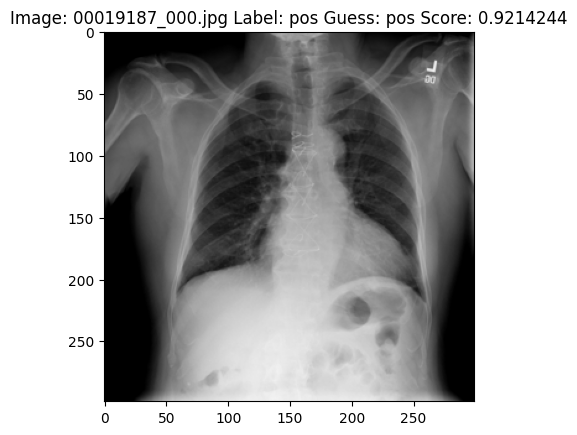

In [ ]:
import random
n = random.randint(0, len(df)-1)
show_df_row(df.iloc[n])

###5.2 Show Table of images

In [ ]:
df[::5][['filename', 'label',"guess","confidence"]]

,filename,label,guess,confidence
0,00013615_052.jpg,pos,pos,0.984043
5,00019187_000.jpg,pos,pos,0.921424
10,00004533_014.jpg,pos,pos,0.877944
15,00016414_000.jpg,pos,pos,0.788136
20,00000087_000.jpg,neg,pos,0.693979
25,00000090_002.jpg,neg,pos,0.603835
30,00000093_002.jpg,neg,pos,0.545232
35,00004344_014.jpg,pos,neg,0.470473
40,00030279_000.jpg,pos,neg,0.370510
45,00000091_006.jpg,neg,neg,0.326562


###5.3 Show Histogram

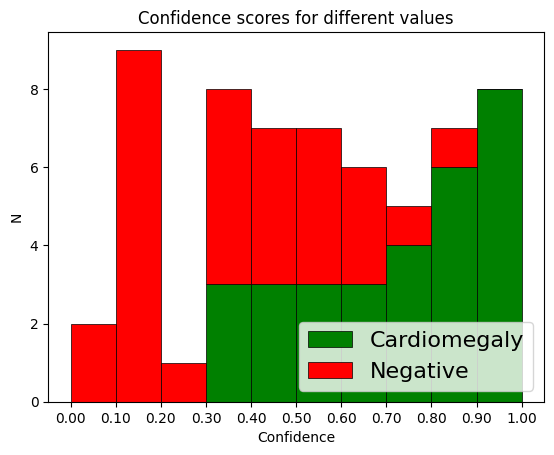

In [ ]:
pos = df.loc[df['label'] == "pos"]["confidence"]
neg = df.loc[df['label'] == "neg"]["confidence"]
fig, ax = plt.subplots()
n, bins, patches = plt.hist([pos,neg], np.arange(0.0, 1.1, 0.1).tolist(), edgecolor='black', linewidth=0.5, density=False, histtype='bar', stacked=True, color=['green', 'red'], label=[finding, 'Negative'])
plt.xlabel('Confidence')
plt.ylabel('N')
plt.xticks(bins)
ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
plt.title('Confidence scores for different values')
plt.legend(loc="lower right", fontsize=16)
plt.show()

###5.4 Create cutoff point

In [ ]:
cutoff = 0.79 #@param {type:"slider", min:0, max:1, step:0.01}

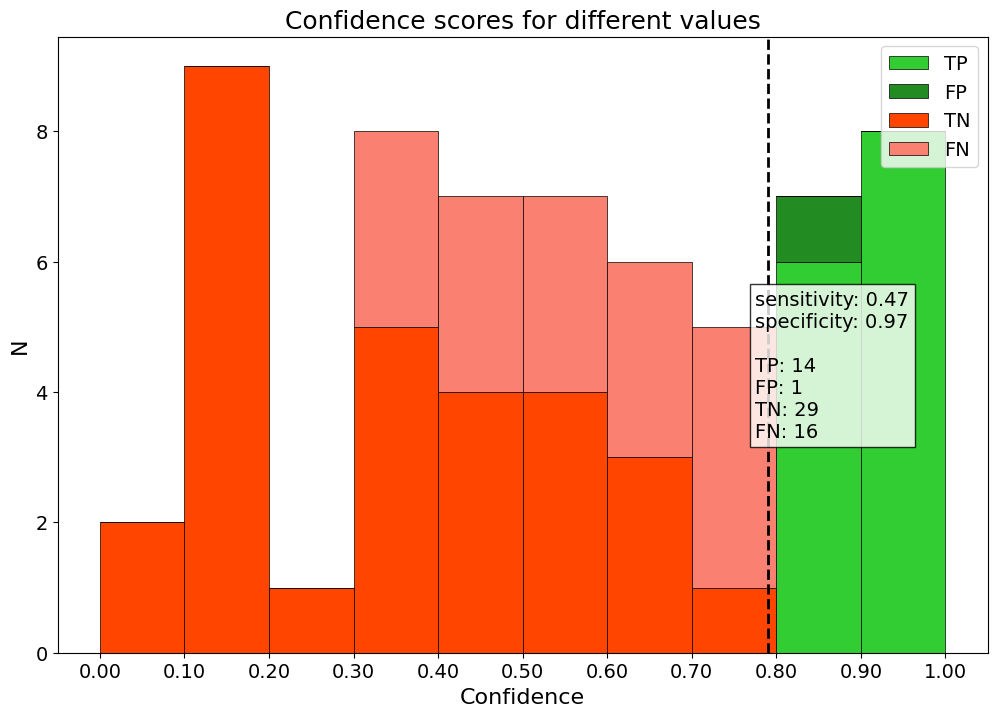

In [ ]:
def create_with_cutoff(cutoff):
    __, ax = plt.subplots(figsize=(12, 8))  # Increased figure size
    TP = df.loc[(df['label'] == "pos") & (df["confidence"] > cutoff)]["confidence"]
    FP = df.loc[(df['label'] == "neg") & (df["confidence"] > cutoff)]["confidence"]
    FN = df.loc[(df['label'] == "pos") & (df["confidence"] < cutoff)]["confidence"]
    TN = df.loc[(df['label'] == "neg") & (df["confidence"] < cutoff)]["confidence"]

    # Plot the histogram
    plt.hist([TP, FP, TN, FN], bins=np.arange(0.0, 1.1, 0.1).tolist(),
             edgecolor='black', linewidth=0.5, density=False, histtype='bar',
             stacked=True, color=['limegreen', 'forestgreen', 'orangered', 'salmon'],
             label=['TP', 'FP', 'TN', 'FN'])

    plt.xlabel('Confidence', fontsize=16)
    plt.ylabel('N', fontsize=16)
    plt.xticks(np.arange(0.0, 1.1, 0.1), fontsize=14)
    plt.yticks(fontsize=14)
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    plt.title('Confidence scores for different values', fontsize=18)
    plt.axvline(cutoff, color='k', linestyle='dashed', linewidth=2)
    plt.legend(loc="upper right", fontsize=14)  # Adjusted legend location to avoid overlap

    # Calculate statistics
    sens = round(len(TP) / (len(TP) + len(FN)), 2)
    spec = round(len(TN) / (len(TN) + len(FP)), 2)
    stats = f"sensitivity: {sens}\nspecificity: {spec}\n\nTP: {len(TP)}\nFP: {len(FP)}\nTN: {len(TN)}\nFN: {len(FN)}"

    # Display stats in a box to make it more readable
    plt.text(0.75, 0.35, stats, fontsize=14, transform=ax.transAxes,
             bbox=dict(facecolor='white', alpha=0.8, edgecolor='black'))

    plt.show()

create_with_cutoff(cutoff)


###5.5 Show ROC Curve

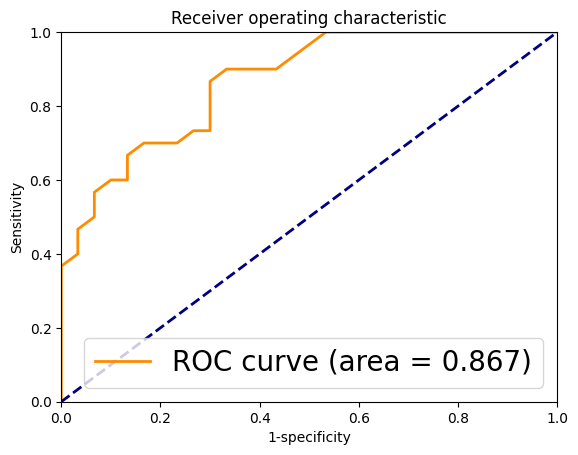

In [ ]:
def create_auc_curve(classifications):
  squares = {}
  for x in classifications:
    conf = x[4]
    TP, FP, TN, FN = 0, 0, 0, 0
    for row in classifications:
      assert (row[2] == "neg" or row[2] == "pos")
      if row[2] == "neg":
        if float(row[4]) < conf: TN += 1
        else: FP += 1
      else:
        if float(row[4]) > conf: TP += 1
        else: FN += 1
    squares[conf] = [TP, FP, TN, FN]
  # now we have a list of stuff: convert to
  sens_spec = {}
  for entry in squares:
    sens = squares[entry][0] / float(squares[entry][0] + squares[entry][3])
    spec = squares[entry][2] / float(squares[entry][2] + squares[entry][1])
    sens_spec[entry] = (1-spec, sens)
  return squares, sens_spec

squares, sens_spec = create_auc_curve(sorted_results)

x = []
y = []
for point in sens_spec.keys():
  x.append(sens_spec[point][0])
  y.append(sens_spec[point][1])

auc = sklearn.metrics.auc(x, y)

plt.figure()
lw = 2
plt.plot(x, y, color='darkorange', lw=lw, label='ROC curve (area = %0.3f)' % auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.ylabel('Sensitivity')
plt.xlabel('1-specificity')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right", fontsize=20)
plt.show()

###5.6 Save Model

(this part is optional)

In [ ]:
model.export('/content/export/'+finding)
!zip -r /content/{finding}.zip /content/export/{finding}

Saved artifact at '/content/export/Cardiomegaly'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 299, 299, 3), dtype=tf.float32, name='keras_tensor_311')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  132334668546640: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132334485262352: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132334503342704: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132334383891552: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132334383893136: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132334713509264: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132334661694064: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132334661696176: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132334661692128: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132334657228816: TensorSpec(shape=(), dtype=tf.resource, name=None)
